In [1]:
import os
import json

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
# from rembg import remove

import torch
import timm
import cv2
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader 
from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seed = 42
torch.manual_seed(seed)
if device == 'cuda':
  torch.cuda.manual_seed_all(seed)

In [17]:
key = 'oil'

valid_images = []                                                       # valid셋에 대해서도 동일한 작업을 위해 두 개의 리스트를 선언한다.
valid_labels = []
valid_path = '../dataset/valid' 
with open(os.path.join(valid_path, "annotations.json"), "r") as json_file:
    valid_ann = json.load(json_file)
images_info = valid_ann['images']

for image_info in images_info:
    image_name = image_info['file_name']                                # 이미지 파일의 이름을 가져온다.
    file_name = image_name.replace('jpg', 'json')                       # 이미지에 대한 라벨링 json파일의 이름을 저장한다. (.jpg를 .json으로 변경하면 된다.)

    with open(os.path.join(valid_path, file_name), "r") as json_file:   # json 파일에 접근하여 json 파일을 불러온다.
        img_json = json.load(json_file)             
    
    label = img_json[key]                                               # 학습하고자 하는 category의 라벨을 저장한다.
    
    if label < 0: continue                                              # 라벨이 -2, -1인 경우 학습에서 제외하여야 한다.
    
    image_path = os.path.join(valid_path, image_name)                   # 이미지 경로를 불러온다.
    image = cv2.imread(image_path)                                      # 이미지를 불러오고 BGR을 RGB로 변경해준다.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    
    valid_images.append(image)
    valid_labels.append(label)

In [18]:
train_path = '../dataset/train' 
with open(os.path.join(train_path, "annotations.json"), "r") as json_file:
    train_ann = json.load(json_file)
images_info = train_ann['images']

for image_info in images_info:
    image_name = image_info['file_name']                                # 이미지 파일의 이름을 가져온다.
    file_name = image_name.replace('jpg', 'json')                       # 이미지에 대한 라벨링 json파일의 이름을 저장한다. (.jpg를 .json으로 변경하면 된다.)

    with open(os.path.join(train_path, file_name), "r") as json_file:   # json 파일에 접근하여 json 파일을 불러온다.
        img_json = json.load(json_file)             
    
    label = img_json[key]                                               # 학습하고자 하는 category의 라벨을 저장한다.
    
    if label == 4:
        image_path = os.path.join(train_path, image_name)                   # 이미지 경로를 불러온다.
        image = cv2.imread(image_path)                                      # 이미지를 불러오고 BGR을 RGB로 변경해준다.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        valid_images.append(image)
        valid_labels.append(label)
    

In [19]:
class ValidDataset(Dataset):
  def __init__(self, images, labels, transform=None):
    self.images = images
    self.labels = labels
    self.transform = transform
  def __len__(self):
    return len(self.labels)
  
  def __getitem__(self, index):
    image = self.images[index]

    if self.transform is not None:
      image = self.transform(image=image)['image']

    label = self.labels[index]
    return image, label

In [20]:
valid_transform = A.Compose([
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

In [21]:
valid_dataset = ValidDataset(valid_images, valid_labels, valid_transform)
valid_loader = DataLoader(valid_dataset, batch_size = 1, shuffle=True, drop_last=True)

In [24]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=5)

Loaded pretrained weights for efficientnet-b0


In [41]:
model_path = './epoch30/final_model/latest.pth'
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint, strict=False)

<All keys matched successfully>

In [ ]:
y_pred = []
y_true = []
# iterate over test data
for inputs, labels in tqdm(valid_loader):
        hypothesis = model(inputs) # Feed Network

        output = (torch.max(torch.exp(hypothesis), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

In [ ]:
cf_matrix = confusion_matrix(y_true, y_pred)

In [ ]:
classes = ('0', '1', '2', '3', '4')

df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])

In [ ]:
sums = df_cm.sum(axis=1)
matrix = []

for i in range(5):
    matrix.append(df_cm.iloc[i]/sums.iloc[i])
matrix = pd.DataFrame(matrix)
matrix=round(matrix, 3)

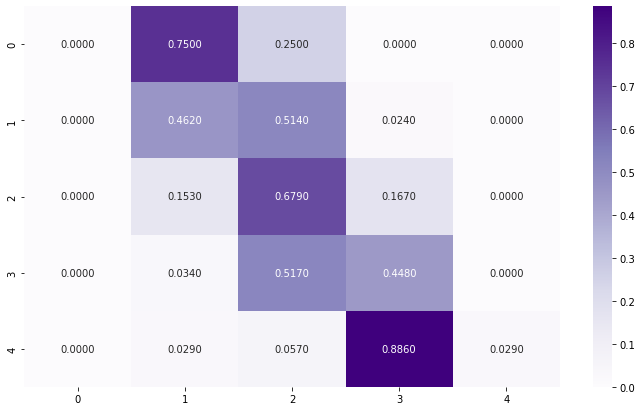

In [69]:
classes = ('0', '1', '2', '3', '4')

df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))

heatmap = sn.heatmap(data=matrix, annot=True, fmt='.4f', cmap='Purples')
plt.show()